In [6]:
import pandas as pd

data = pd.read_csv('https://www.sidc.be/SILSO/INFO/sndtotcsv.php', sep=';',
                 names=['Year','Month','Day','Decimal Date','Daily Sunspot Number',
                       'Standard Deviation','Number of Observations','Definitive/provisional indicator'])
data.head(1)

,Year,Month,Day,Decimal Date,Daily Sunspot Number,Standard Deviation,Number of Observations,Definitive/provisional indicator
0,1818,1,1,1818.001,-1,-1.0,0,1


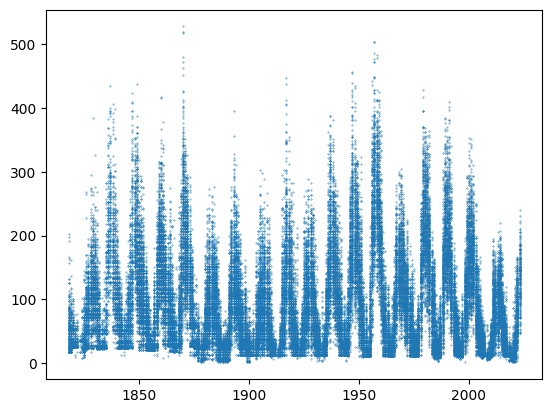

In [7]:
import matplotlib.pyplot as plt
import numpy as np
df = data.loc[data['Daily Sunspot Number']>0].reset_index(drop=True)
plt.scatter(df['Year'],df['Daily Sunspot Number'],s=0.1)
plt.show()

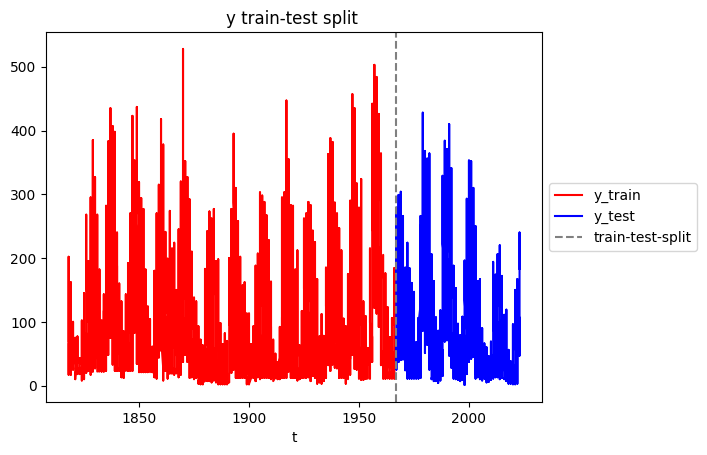

In [8]:
import pymc3 as pm
import arviz as az

n = int(len(df)) 

x = df['Year'].values#.reshape(n, 1)
y = df['Daily Sunspot Number'].values#.reshape(n, 1)

prop_train = 0.7 #70% it's size
n_train = round(prop_train * n)

x_train = x[:n_train]
y_train = y[:n_train]

x_test = x[n_train:]
y_test = y[n_train:]

# Plot.
fig, ax = plt.subplots()
ax.plot(x_train.flatten(), y_train.flatten(), color='red', label='y_train')
ax.plot(x_test.flatten(), y_test.flatten(), color='blue', label='y_test')
ax.axvline(x_train.flatten()[-1], color='grey', linestyle='--', label='train-test-split')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='y train-test split ', xlabel='t', ylabel='');
plt.show()

In [14]:
import pymc3 as pm
import pymc3_ext as pmx
import aesara_theano_fallback.tensor as tt
from celerite2.theano import terms, GaussianProcess

def GP_model(x,y,yerr,LS_period):
    with pm.Model() as model:

        # The mean flux of the time series
        mean = pm.Normal("mean", mu=np.nanmean(y), sigma=10.0)

        # A jitter term describing excess white noise
        log_jitter = pm.Normal("log_jitter", mu=np.log(np.mean(yerr)), sigma=2.0)

        # A term to describe the non-periodic variability
        sigma = pm.InverseGamma(
            "sigma", **pmx.estimate_inverse_gamma_parameters(1.0, 5.0)
        )
        rho = pm.InverseGamma(
            "rho", **pmx.estimate_inverse_gamma_parameters(0.5, 2.0)
        )

        # The parameters of the RotationTerm kernel
        sigma_rot = pm.InverseGamma(
            "sigma_rot", **pmx.estimate_inverse_gamma_parameters(1.0, 5.0)
        )            
#         log_period = pm.Bound(pm.Normal, lower=np.log(min_period), upper=np.log(max_period))("log_period", mu=np.log(LS_period), sigma=2.0)
        log_period = pm.Normal("log_period", mu=np.log(LS_period), sigma=2.0)
        
        period = pm.Deterministic("period", tt.exp(log_period))
        log_Q0 = pm.HalfNormal("log_Q0", sigma=2.0)
        log_dQ = pm.Normal("log_dQ", mu=0.0, sigma=2.0)
        f = pm.Uniform("f", lower=0.1, upper=1.0)

        # Set up the Gaussian Process model
        kernel = terms.SHOTerm(sigma=sigma, rho=rho, Q=1 / 3.0)
        kernel += terms.RotationTerm(
            sigma=sigma_rot,
            period=period,
            Q0=tt.exp(log_Q0),
            dQ=tt.exp(log_dQ),
            f=f,
        )
        gp = GaussianProcess(
            kernel,
            t=x,
            diag=yerr**2 + tt.exp(2 * log_jitter),
            mean=mean,
            quiet=True,
        )

        # Compute the Gaussian Process likelihood and add it into the
        # the PyMC3 model as a "potential"
        gp.marginal("gp", observed=y)

        # Compute the mean model prediction for plotting purposes
        pm.Deterministic("pred", gp.predict(y))

        # Optimize to find the maximum a posteriori parameters
        map_soln = pmx.optimize()
    
    return map_soln, model, gp

def get_trace_and_GP_model_and_period(map_soln,model,y,tune,draws,target_accept):
    with model:
        trace = pmx.sample(
            tune=tune,
            draws=draws,
            start=map_soln,
            cores=2,
            chains=2,
            target_accept=target_accept,
            return_inferencedata=True,
            random_seed=[10863087, 10863088],
        )
        
    #Pull mcmc model 
    flat_samps = trace.posterior.stack(sample=("chain","draw"))
    unscaled_model = map_soln['pred']
    mcmc_model = np.percentile(flat_samps['pred'],[16,50,84],axis=-1)
    period_samples = np.asarray(trace.posterior["period"]).flatten()
    unscaled_mcmc_model = mcmc_model[1]
    resid = y-unscaled_mcmc_model
    newy=resid
    
    counts, bins = np.histogram(period_samples, bins=int(draws/2), density=True) #why bins=draws/2? Arbitrary choice
    peak_ind = np.argmax(counts) #select period by one with highest posterior density
    gp_period = bins[peak_ind]
    
    return trace, unscaled_model,mcmc_model, unscaled_mcmc_model, newy, gp_period,period_samples

In [15]:
LS_period = 11 #years as a loose guess

x = np.array(df['Year'])[0:int(len(df['Year'])/10)]
y = np.array(df['Daily Sunspot Number'])[0:int(len(df['Year'])/10)]
yerr = np.ones_like(y)*np.nanstd(y)
# 
#step 3: create MAP model with GP:
map_soln, model,gp = GP_model(x,y,yerr,LS_period)
#
tune = 100
draws = 100
target_accept = 0.9
#step 4: perform MCMC and get trace
trace, unscaled_model, mcmc_model, unscaled_mcmc_model, newy, gp_period,period_samples = get_trace_and_GP_model_and_period(map_soln,model,y,tune,draws,target_accept)

optimizing logp for variables: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


message: Optimization terminated successfully.
logp: -34771.74940743178 -> -32778.0709535275
/Users/daxfeliz/opt/anaconda3/lib/python3.9/site-packages/pymc3_ext/sampling/schedule.py:33: UserWarning: there are not enough tuning steps to accomodate the tuning schedule; assigning automatically as 20%/70%/10%
  warnings.warn(
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


Sampling 2 chains for 100 tune and 100 draw iterations (200 + 200 draws total) took 27 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 25% for some parameters.


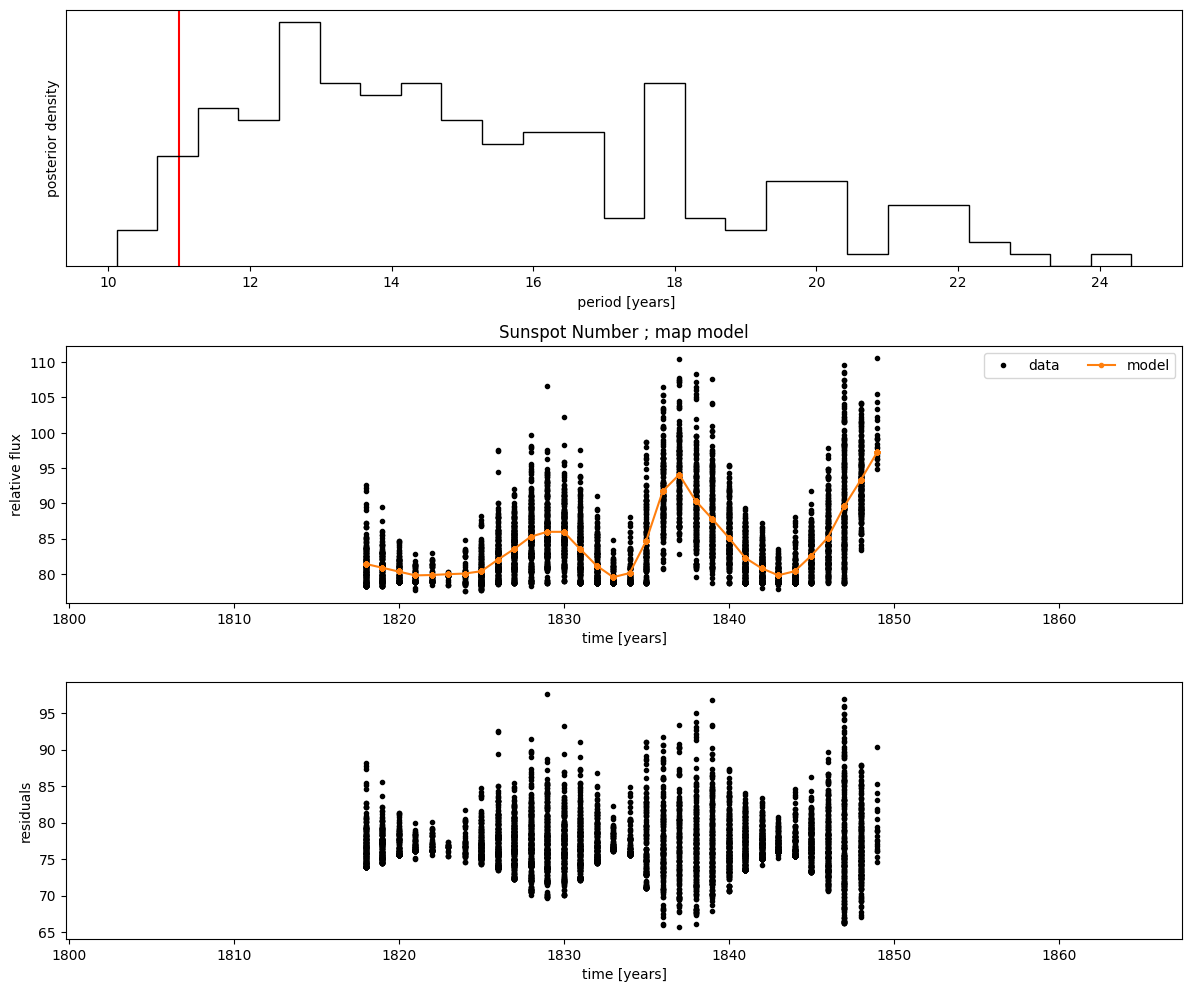

In [16]:
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(12,10))

ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)



period_samples = np.asarray(trace.posterior["period"]).flatten()
ax1.hist(period_samples, 25, histtype="step", color="k", density=True)
ax1.set_yticks([])
ax1.set_xlabel(" period [years]")
ax1.set_ylabel("posterior density")
ax1.axvline(x=11,color='red',zorder=-10)


ax2.plot(x, np.nanmedian(y)*(1+y/1e3), "k.", label="data")
ax2.plot(x, np.nanmedian(y)*(1+map_soln["pred"]/1e3), marker='.',linestyle='-', color="C1", label="model")
ax2.set_xlim(x.min()-x.min()*0.01, x.max()+x.max()*0.01)
ax2.legend(fontsize=10,ncol=2)
ax2.set_xlabel("time [years]")
ax2.set_ylabel("relative flux")
ax2.set_title("Sunspot Number ; map model")
# can we simply subtract to remove variability?

resid = y-map_soln["pred"]    
newy = np.nanmedian(y)*(1+resid/1e3) #put it back to input normalized flux scale

ax3.plot(x, newy, "k.")
ax3.set_xlim(x.min()-x.min()*0.01, x.max()+x.max()*0.01)
ax3.set_xlabel("time [years]")
ax3.set_ylabel("residuals")

fig.tight_layout(pad=1)
#plt.close()    
plt.show()

In [ ]:
# predicting new data

In [45]:
X_new = np.linspace(np.max(x), np.max(x)+20, len(x))#[:, None]



In [46]:
with model:
#     mu, var = gp.predict(
#         X_new, point=az.extract_dataset(trace.posterior.sel( draw=[int(draws/2)] ) ).squeeze(), diag=True
#     )
    mu, var = gp.predict(y, t=X_new, return_var=True)
    
sd = np.sqrt(var)


# # draw plot
# fig = plt.figure(figsize=(12, 5))
# ax = fig.gca()

# # plot mean and 2sigma intervals
# Nsigma=2
# plt.plot(X_new, mu, "r", lw=2, label="mean and 1σ region")
# plt.plot(X_new, mu + Nsigma * sd, "r", lw=1)
# plt.plot(X_new, mu - Nsigma * sd, "r", lw=1)
# plt.fill_between(X_new.flatten(), mu - Nsigma * sd, mu + Nsigma * sd, color="r", alpha=0.5)

# # plot original data and true function
# plt.plot(X, y, "ok", ms=3, alpha=1.0, label="observed data")
# plt.plot(X, f_true, "dodgerblue", lw=3, label="true f")

# plt.xlabel("x")
# plt.ylim([-13, 13])
# plt.title("predictive mean and 2sigma interval")
# plt.legend()
# plt.show()

TypeError: object of type 'TensorVariable' has no len()

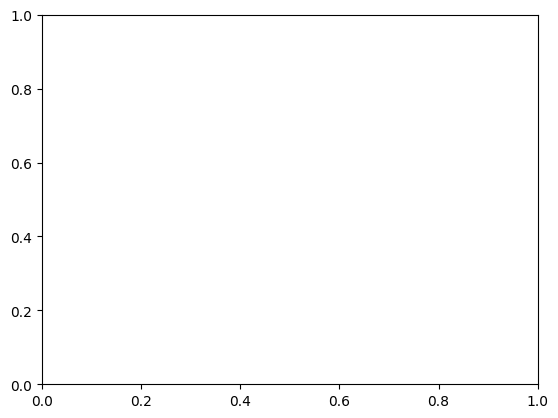

In [47]:
mu, variance = gp.predict(y, t=X_new, return_var=True)
sigma = np.sqrt(variance)
plt.plot(X_new, mu, label="prediction")
plt.fill_between(X_new, mu - sigma, mu + sigma, color="C0", alpha=0.2)
plt.show()

In [48]:
def plot_prediction(gp,x,y, true_x,true_y, yerr):
    plt.plot(true_x, true_y, "k", lw=1.5, alpha=0.3, label="data")
    plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0, label="truth")

    if gp:
        mu, variance = gp.predict(y, t=true_x, return_var=True)
        sigma = np.sqrt(variance)
        plt.plot(true_x, mu, label="prediction")
        plt.fill_between(true_x, mu - sigma, mu + sigma, color="C0", alpha=0.2)

    plt.xlabel("x [day]")
    plt.ylabel("y [ppm]")
    plt.xlim(0, 10)
    plt.ylim(-2.5, 2.5)
    plt.legend()
    plt.show()


In [ ]:
plot_prediction(gp,x,y,X_new,y,yerr)